## Solving a system of linear algebraic equations (SLAE)

We consider a linear system
$$
A x = b,\qquad A\in\mathbb{R}^{n\times n},\ x,b\in\mathbb{R}^n.
$$

---

### Accuracy measure (residual)
For any approximate solution $x_k$, the residual is
$$
r_k = b - A x_k,\qquad \|r_k\|_2 \text{ should decrease to } 0
$$
In iterative methods we often use the relative residual
$$
\frac{\|r_k\|_2}{\|b\|_2}
$$

---

## Direct methods

### 1) Gaussian elimination with partial pivoting (GEPP)
Transforms $A$ to an upper-triangular matrix via row operations.  
Partial pivoting swaps the current row with the row below having the largest $|a_{ik}|$ in the pivot column $k$ to improve numerical stability.  
Then solve by back substitution.

### 2) LU decomposition (with pivoting):  $P A = L U$
Factorization into a permutation matrix $P$, unit lower-triangular $L$, and upper-triangular $U$:
$$
P A = L U.
$$
Solve in two triangular steps:
$$
L y = P b,\qquad U x = y.
$$
(Without pivoting LU may fail if a pivot becomes zero/small; with pivoting it is broadly applicable.)

## Iterative methods

### 3) Jacobi
Splitting $A = D + (L+U)$ where $D$ is diagonal:
$$
x^{(k+1)} = D^{-1}\bigl(b - (L+U)x^{(k)}\bigr).
$$

### 4) Gauss–Seidel
Uses newest available components during the sweep:
$$
(D+L)x^{(k+1)} = b - U x^{(k)}.
$$

### 5) SOR (Successive Over-Relaxation)
Relaxed Gauss–Seidel with $\omega\in(0,2)$:
$$
x^{(k+1)} = (1-\omega)x^{(k)} + \omega\,x_{\text{GS}}^{(k+1)}.
$$
Often $\omega>1$ accelerates convergence, but too large $\omega$ may destabilize.

### 6) Gradient descent 
Minimize
$$
\phi(x) = \tfrac12\|Ax-b\|_2^2,\quad \nabla\phi(x)=A^\top(Ax-b)=-A^\top r.
$$
Update
$$
x^{(k+1)} = x^{(k)} + \alpha A^\top r_k,
$$

### 7) Minimal residual 
Uses direction $r_k$ and chooses $\alpha_k$ to minimize $\|r_{k+1}\|_2$:
$$
x^{(k+1)} = x^{(k)} + \alpha_k r_k,\qquad
\alpha_k = \arg\min_\alpha \|r_k - \alpha A r_k\|_2.
$$

### 8) Conjugate gradient (CG) and BiCGSTAB
- CG requires symmetric positive definite matrices. For non-symmetric $A$, there's a workaround:
$$
A^\top A x = A^\top b
$$
- BiCGSTAB is a Krylov method designed for non-symmetric systems


## Example

We solve the system:
$$
\begin{cases}
x_1 + x_2 + \cdots + x_{99} + x_{100} = 100, \\
x_1 + 10x_2 + x_3 = 99, \\
x_2 + 10x_3 + x_4 = 98, \\
\qquad \vdots \\
x_{98} + 10x_{99} + x_{100} = 2, \\
x_{99} + x_{100} = 1.
\end{cases}
$$


In [106]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
# Build the SLAE
n = 100
A = np.zeros((n, n), dtype=float)
b = np.zeros(n, dtype=float)

A[0, :] = 1.0
b[0] = 100.0

for i in range(1, n - 1):
    A[i, i - 1] = 1.0
    A[i, i] = 10.0
    A[i, i + 1] = 1.0
    b[i] = 100.0 - i

A[n - 1, n - 2] = 1.0
A[n - 1, n - 1] = 1.0
b[n - 1] = 1.0

def rel_residual(A, b, x):
    r = b - A @ x
    return np.linalg.norm(r) / np.linalg.norm(b)

def plot_residual(hist, title):
    plt.figure(figsize=(8, 4.5))
    plt.semilogy(np.arange(len(hist)), hist)
    plt.xlabel("Iteration")
    plt.ylabel(r"Relative residual $\|b-Ax_k\|_2/\|b\|_2$")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [108]:
# Gaussian elimination with partial pivoting (GEPP)
def gaussian_elimination_pp(A, b):
    A = A.astype(float).copy()
    b = b.astype(float).copy()
    n = A.shape[0]

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(A[k:, k]))
        assert A[pivot, k] != 0

        if pivot != k:
            A[[k, pivot]] = A[[pivot, k]]
            b[[k, pivot]] = b[[pivot, k]]

        for i in range(k + 1, n):
            m = A[i, k] / A[k, k]
            A[i, k:] -= m * A[k, k:]
            b[i] -= m * b[k]

    x = np.zeros(n, dtype=float)
    for i in range(n - 1, -1, -1):
        assert A[i, i] != 0

        x[i] = (b[i] - A[i, i+1:] @ x[i+1:]) / A[i, i]

    return x

x_gepp = gaussian_elimination_pp(A, b)
print("GEPP relative residual:", rel_residual(A, b, x_gepp))


GEPP relative residual: 1.7359475625055162e-16


In [109]:
# LU decomposition with partial pivoting: PA = LU
def lu_decomposition_pp(A):
    A = A.astype(float).copy()
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n, dtype=float)
    P = np.arange(n)

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(U[k:, k]))

        if pivot != k:
            U[[k, pivot]] = U[[pivot, k]]
            P[[k, pivot]] = P[[pivot, k]]
            if k > 0:
                L[[k, pivot], :k] = L[[pivot, k], :k]

        for i in range(k + 1, n):
            L[i, k] = U[i, k] / U[k, k]
            U[i, k:] -= L[i, k] * U[k, k:]
            U[i, k] = 0.0

    return P, L, U

def forward_substitution(L, b):
    n = L.shape[0]
    y = np.zeros(n, dtype=float)
    for i in range(n):
        y[i] = b[i] - L[i, :i] @ y[:i]
    return y

def backward_substitution(U, y):
    n = U.shape[0]
    x = np.zeros(n, dtype=float)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
    return x

P, L, U = lu_decomposition_pp(A)
y = forward_substitution(L, b[P])
x_lu = backward_substitution(U, y)

print("LU(PP) relative residual:", rel_residual(A, b, x_lu))

LU(PP) relative residual: 1.7359475625055162e-16


Jacobi iterations: 39 final rel. residual: 4.1509843770832615e-16


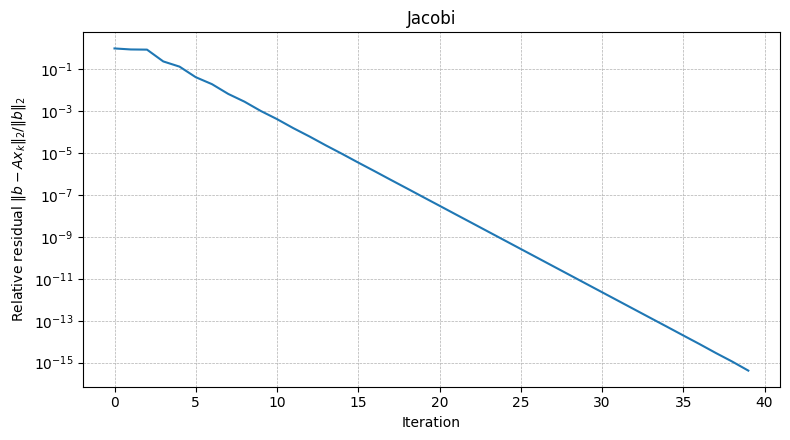

In [110]:
# Jacobi method
def jacobi(A, b, x0=None, tol=1e-15, max_iter=50000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[0]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    D = np.diag(A)

    R = A - np.diagflat(D)
    bnorm = np.linalg.norm(b)
    hist = []

    for _ in range(max_iter):
        r = b - A @ x
        rr = np.linalg.norm(r) / bnorm
        hist.append(rr)
        if rr < tol:
            break
        x = (b - R @ x) / D

    return x, np.array(hist)

x_jacobi, h_jacobi = jacobi(A, b, x0=np.zeros(n), tol=1e-15, max_iter=50000)
print("Jacobi iterations:", len(h_jacobi)-1, "final rel. residual:", h_jacobi[-1])
plot_residual(h_jacobi, "Jacobi")


Gauss-Seidel iterations: 16 final relative residual: 2.3601705089987323e-16


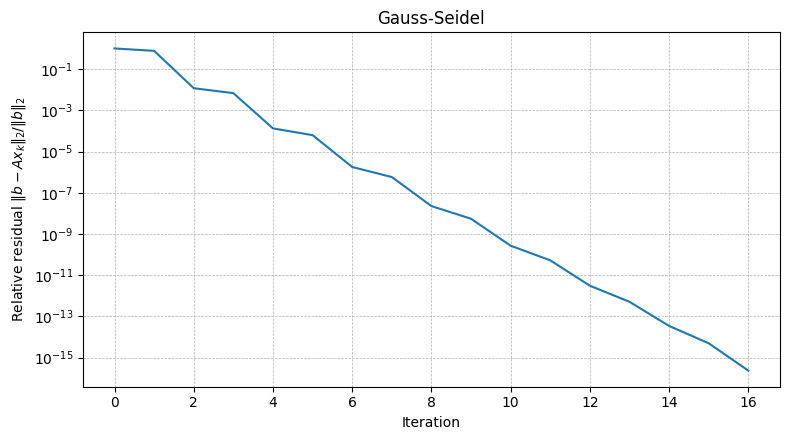

In [111]:
# Gauss-Seidel method
def gauss_seidel(A, b, x0=None, tol=1e-15, max_iter=50000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[0]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    bnorm = np.linalg.norm(b)
    hist = []

    for _ in range(max_iter):
        r = b - A @ x
        rr = np.linalg.norm(r) / bnorm
        hist.append(rr)
        if rr < tol:
            break

        for i in range(n):
            s1 = A[i, :i] @ x[:i]
            s2 = A[i, i+1:] @ x[i+1:]
            x[i] = (b[i] - s1 - s2) / A[i, i]

    return x, np.array(hist)

x_gs, h_gs = gauss_seidel(A, b, x0=np.zeros(n), tol=1e-15, max_iter=50000)
print("Gauss-Seidel iterations:", len(h_gs)-1, "final relative residual:", h_gs[-1])
plot_residual(h_gs, "Gauss-Seidel")


SOR(omega=1.05) iterations: 19 final relative residual: 2.3869376280293166e-16


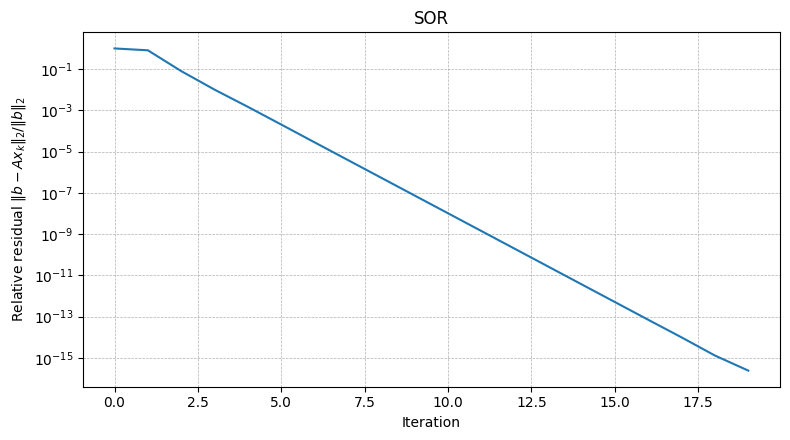

In [112]:
# SOR method
def sor(A, b, omega=1.2, x0=None, tol=1e-15, max_iter=50000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[0]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    bnorm = np.linalg.norm(b)
    hist = []

    for _ in range(max_iter):
        r = b - A @ x
        rr = np.linalg.norm(r) / bnorm
        hist.append(rr)
        if rr < tol:
            break

        for i in range(n):
            if A[i, i] == 0:
                raise np.linalg.LinAlgError("Zero diagonal entry: SOR cannot proceed.")
            s1 = A[i, :i] @ x[:i]
            s2 = A[i, i+1:] @ x[i+1:]
            x_gs = (b[i] - s1 - s2) / A[i, i]
            x[i] = (1 - omega) * x[i] + omega * x_gs

    return x, np.array(hist)

x_sor, h_sor = sor(A, b, omega=1.05, x0=np.zeros(n), tol=1e-15, max_iter=50000)
print("SOR(omega=1.05) iterations:", len(h_sor)-1, "final relative residual:", h_sor[-1])
plot_residual(h_sor, "SOR")


GD const-α iterations: 84799 final relative residual: 9.999704271755287e-11


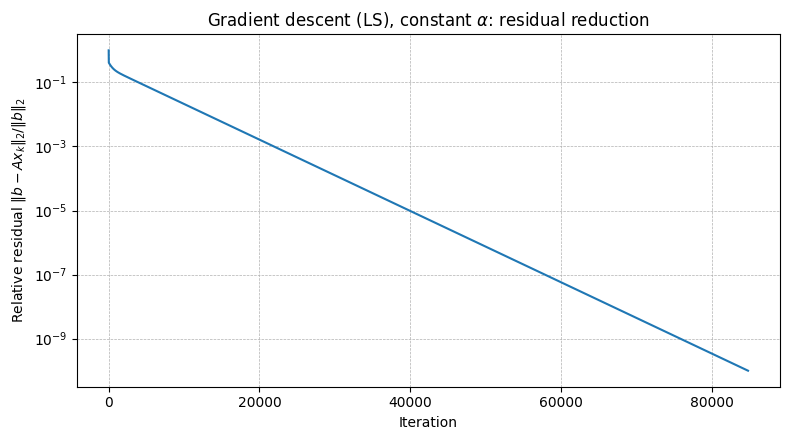

In [113]:
# Gradient descent

def gradient_descent_ls_const_alpha(A, b, alpha=1e-3, x0=None, tol=1e-10, max_iter=200000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[1]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    bnorm = np.linalg.norm(b)
    hist = []

    for _ in range(max_iter):
        r = b - A @ x
        rr = np.linalg.norm(r) / bnorm
        hist.append(rr)
        if rr < tol:
            break

        x = x + alpha * (A.T @ r)

    return x, np.array(hist)

x_gd_const, h_gd_const = gradient_descent_ls_const_alpha(A, b, alpha=1*1e-3, x0=np.zeros(n), tol=1e-10, max_iter=2000000)
print("GD const-α iterations:", len(h_gd_const)-1, "final relative residual:", h_gd_const[-1])
plot_residual(h_gd_const, r"Gradient descent (LS), constant $\alpha$: residual reduction")


Minimal residual iterations: 10224 final rel. residual: 9.990479062272006e-11


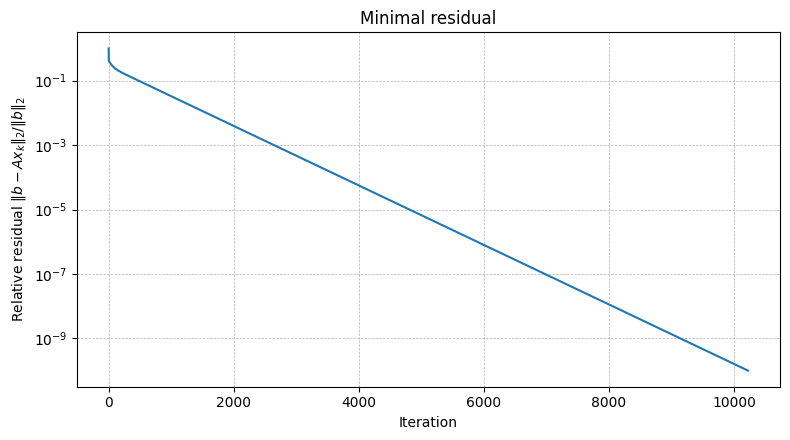

In [117]:
# Minimal residual
def minimal_residual(A, b, x0=None, tol=1e-10, max_iter=200000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[1]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    bnorm = np.linalg.norm(b)
    hist = []

    for _ in range(max_iter):
        r = b - A @ x
        rr = np.linalg.norm(r) / bnorm
        hist.append(rr)
        if rr < tol:
            break

        rN = A.T @ r                 # residual of normal equations
        AtA_rN = A.T @ (A @ rN)      # (A^T A) rN

        denom = AtA_rN @ AtA_rN
        if denom == 0:
            break

        alpha = (rN @ AtA_rN) / denom
        x = x + alpha * rN

    return x, np.array(hist)


x_mr, h_mr = minimal_residual(A, b, x0=np.zeros(n), tol=1e-10, max_iter=200000)
print("Minimal residual iterations:", len(h_mr)-1, "final rel. residual:", h_mr[-1])
plot_residual(h_mr, "Minimal residual")


CGNR iterations: 30 final rel. residual: 7.991984256965596e-16


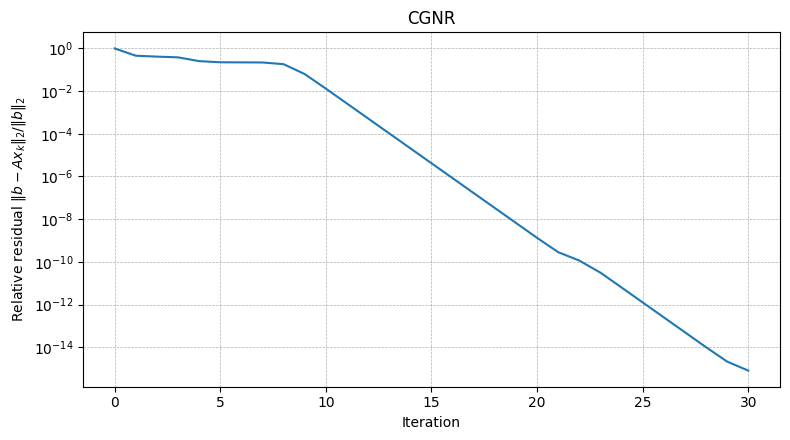

In [115]:
# Conjugate Gradient on normal equations (CGNR)
def cgnr(A, b, x0=None, tol=1e-15, max_iter=200000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[1]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    bnorm = np.linalg.norm(b)
    r = b - A @ x
    z = A.T @ r
    p = z.copy()

    zz_old = z @ z
    hist = [np.linalg.norm(r) / bnorm]

    for _ in range(max_iter):
        if hist[-1] < tol:
            break

        Ap = A @ p
        denom = Ap @ Ap
        if denom == 0:
            break

        alpha = zz_old / denom
        x = x + alpha * p
        r = r - alpha * Ap
        z = A.T @ r

        zz_new = z @ z
        beta = zz_new / zz_old if zz_old != 0 else 0.0
        p = z + beta * p
        zz_old = zz_new

        hist.append(np.linalg.norm(r) / bnorm)

    return x, np.array(hist)

x_cgnr, h_cgnr = cgnr(A, b, x0=np.zeros(n), tol=1e-15, max_iter=200000)
print("CGNR iterations:", len(h_cgnr)-1, "final rel. residual:", h_cgnr[-1])
plot_residual(h_cgnr, "CGNR")


BiCGSTAB iterations: 12 final rel. residual: 9.671479703323125e-16


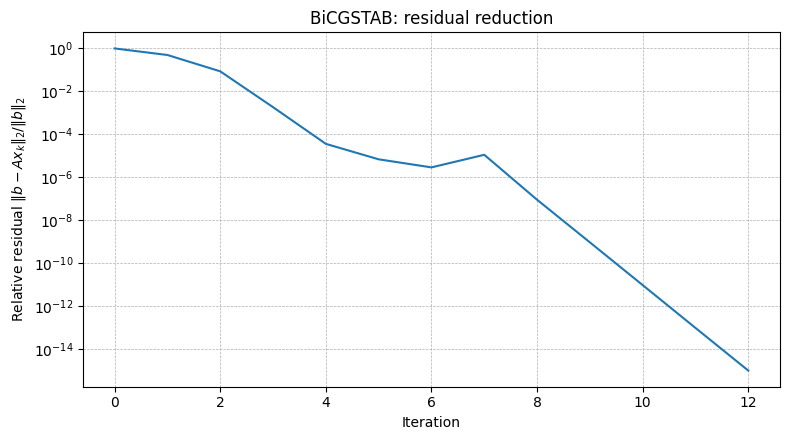

In [116]:
# BiCGSTAB for general (possibly non-symmetric) A
def bicgstab(A, b, x0=None, tol=1e-15, max_iter=200000):
    A = A.astype(float)
    b = b.astype(float)
    n = A.shape[0]
    x = np.zeros(n) if x0 is None else x0.astype(float).copy()

    bnorm = np.linalg.norm(b)
    r = b - A @ x
    r_hat = r.copy()

    rho_old = 1.0
    alpha = 1.0
    omega = 1.0
    v = np.zeros(n)
    p = np.zeros(n)

    hist = [np.linalg.norm(r) / bnorm]

    for _ in range(max_iter):
        if hist[-1] < tol:
            break

        rho_new = r_hat @ r
        if rho_new == 0:
            break

        beta = (rho_new / rho_old) * (alpha / omega)
        p = r + beta * (p - omega * v)

        v = A @ p
        denom = r_hat @ v
        if denom == 0:
            break
        alpha = rho_new / denom

        s = r - alpha * v
        s_rel = np.linalg.norm(s) / bnorm
        if s_rel < tol:
            x = x + alpha * p
            hist.append(s_rel)
            break

        t = A @ s
        tt = t @ t
        if tt == 0:
            break
        omega = (t @ s) / tt
        if omega == 0:
            break

        x = x + alpha * p + omega * s
        r = s - omega * t

        rho_old = rho_new
        hist.append(np.linalg.norm(r) / bnorm)

    return x, np.array(hist)

x_bicg, h_bicg = bicgstab(A, b, x0=np.zeros(n), tol=1e-15, max_iter=200000)
print("BiCGSTAB iterations:", len(h_bicg)-1, "final rel. residual:", h_bicg[-1])
plot_residual(h_bicg, "BiCGSTAB: residual reduction")


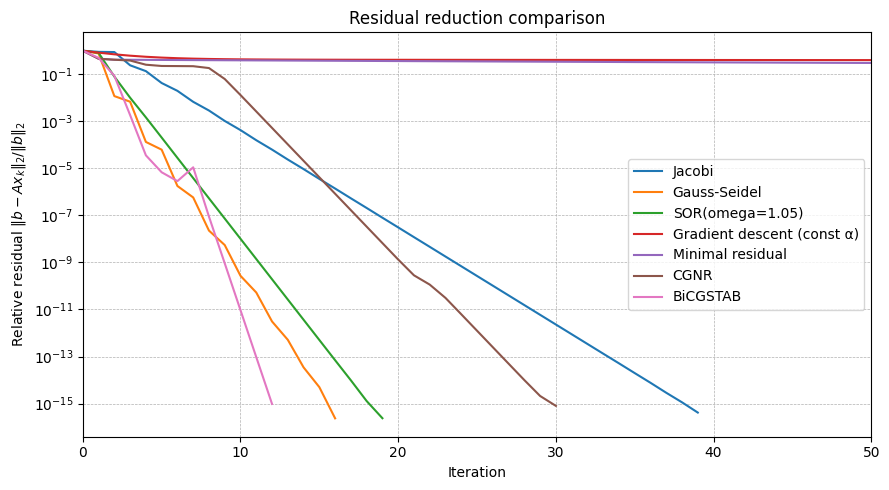

In [121]:
# Final comparison plot

methods_hist = {
    "Jacobi": h_jacobi,
    "Gauss-Seidel": h_gs,
    "SOR(omega=1.05)": h_sor,
    "Gradient descent (const α)": h_gd_const,
    "Minimal residual": h_mr,
    "CGNR": h_cgnr,
    "BiCGSTAB": h_bicg,
}

kmax = 50

plt.figure(figsize=(9, 5))
for name, hist in methods_hist.items():
    m = min(len(hist), kmax + 1)
    plt.semilogy(np.arange(m), hist[:m], label=name)

plt.xlim(0, kmax)
plt.xlabel("Iteration")
plt.ylabel(r"Relative residual $\|b-Ax_k\|_2/\|b\|_2$")
plt.title("Residual reduction comparison")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [132]:
# Final summary table

import pandas as pd
import numpy as np

def sci1(x):
    if x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x))):
        return ""
    x = float(x)
    if x == 0.0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10 ** exp)
    mant = np.round(mant, 1)
    if abs(mant) >= 10:
        mant = mant / 10
        exp += 1
    return f"{mant:.1f}e{exp:+d}"

def iters_to_tol(hist, tol):
    idx = np.where(hist <= tol)[0]
    return int(idx[0]) if idx.size else -1

rows = []

rows.append({
    "method": "GEPP (Gaussian elimination PP)",
    "type": "direct",
    "iters": 0,
    "final_rel_res": rel_residual(A, b, x_gepp),
    "||x - x_GEPP||2": 0.0,
    "min_rel_res_first50": np.nan,
    "iters_to_1e-6": -1,
    "iters_to_1e-10": -1,
})

rows.append({
    "method": "LU (partial pivoting)",
    "type": "direct",
    "iters": 0,
    "final_rel_res": rel_residual(A, b, x_lu),
    "||x - x_GEPP||2": float(np.linalg.norm(x_lu - x_gepp)),
    "min_rel_res_first50": np.nan,
    "iters_to_1e-6": -1,
    "iters_to_1e-10": -1,
})

histories = {
    "Jacobi": (x_jacobi, h_jacobi),
    "Gauss-Seidel": (x_gs, h_gs),
    "SOR(omega=1.05)": (x_sor, h_sor),
    "Gradient descent (const α)": (x_gd_const, h_gd_const),
    "Minimal residual": (x_mr, h_mr),
    "CGNR (AᵀA)": (x_cgnr, h_cgnr),
    "BiCGSTAB": (x_bicg, h_bicg),
}

for name, (x, hist) in histories.items():
    hist = np.asarray(hist, dtype=float)
    rows.append({
        "method": name,
        "type": "iterative",
        "iters": int(len(hist) - 1),
        "final_rel_res": float(hist[-1]),
        "||x - x_GEPP||2": float(np.linalg.norm(x - x_gepp)),
        "min_rel_res_first50": float(np.min(hist[:min(len(hist), 51)])),
        "iters_to_1e-6": int(iters_to_tol(hist, 1e-6)),
        "iters_to_1e-10": int(iters_to_tol(hist, 1e-10)),
    })

summary = pd.DataFrame(rows)

summary["type_order"] = summary["type"].map({"direct": 0, "iterative": 1})
summary = summary.sort_values(["type_order", "final_rel_res", "iters"]).drop(columns=["type_order"])

for c in ["iters", "iters_to_1e-6", "iters_to_1e-10"]:
    summary[c] = summary[c].astype(int)

float_cols = ["final_rel_res", "||x - x_GEPP||2", "min_rel_res_first50"]
summary_fmt = summary.copy()
for c in float_cols:
    summary_fmt[c] = summary_fmt[c].apply(sci1)

summary_fmt


,method,type,iters,final_rel_res,||x - x_GEPP||2,min_rel_res_first50,iters_to_1e-6,iters_to_1e-10
0,GEPP (Gaussian elimination PP),direct,0,1.7e-16,0,,-1,-1
1,LU (partial pivoting),direct,0,1.7e-16,0,,-1,-1
3,Gauss-Seidel,iterative,16,2.4e-16,2.3e-13,2.4e-16,7,11
4,SOR(omega=1.05),iterative,19,2.4e-16,5.9e-14,2.4e-16,8,13
2,Jacobi,iterative,39,4.2e-16,6.1e-14,4.2e-16,17,27
7,CGNR (AᵀA),iterative,30,8.0e-16,3.3e-13,8.0e-16,16,23
8,BiCGSTAB,iterative,12,9.7e-16,8.4e-13,9.7e-16,8,10
6,Minimal residual,iterative,10224,1.0e-10,1.1e-7,3.0e-1,5892,10224
5,Gradient descent (const α),iterative,84799,1.0e-10,1.1e-7,4.0e-1,48864,84799
